# Case study using the datafusiontools package

Import the DataFusionTools package

In [2]:
import datafusiontools as dft
import pickle
from pathlib import Path

2022-09-12 14:32:23,942 | INFO | NumExpr defaulting to 8 threads.


# Data sets

The datasets used in this tutorial are the following:
 - CPT
 - Resistivity

Load the data (available as pickle):

In [3]:
# read pickle file
with open("../data/test_case_DF.pickle", "rb") as fi:
    [cpts, resistivity, ahn] = pickle.load(fi)
print(f"CPTs type: {type(cpts)}")
print(f"resistivity type: {type(resistivity)}")

CPTs type: <class 'dict'>
resistivity type: <class 'dict'>


## Inspect data

In [4]:
list(cpts.keys())[:10]

['CPT000000092613',
 'CPT000000092635',
 'CPT000000092609',
 'CPT000000092599',
 'CPT000000092696',
 'CPT000000092578',
 'CPT000000092690',
 'CPT000000092663',
 'CPT000000065083',
 'CPT000000092547']

In [5]:
cpts["CPT000000092613"].keys()

dict_keys(['coordinates', 'NAP', 'pwp', 'water', 'name', 'depth', 'tip', 'friction', 'friction_nb', 'IC', 'lithology'])

In [6]:
list(resistivity.keys())[:10]

['64961.0 393556.0',
 '64960.0 393552.0',
 '64959.0 393548.0',
 '64959.0 393543.0',
 '64958.0 393539.0',
 '64958.0 393535.0',
 '64957.0 393531.0',
 '64957.0 393526.0',
 '64956.0 393522.0',
 '64955.0 393518.0']

In [7]:
resistivity['64961.0 393556.0'].keys()

dict_keys(['coordinates', 'depth', 'NAP', 'resistivity'])

In [8]:
import numpy as np
location_cpt = []
for name, item in cpts.items():
    location_cpt.append([item["coordinates"][0], item["coordinates"][1]])
location_cpt = np.array(location_cpt).T
location_resistivity = []
for name, item in resistivity.items():
    location_resistivity.append([item["coordinates"][0], item["coordinates"][1]])
location_resistivity = np.array(location_resistivity).T

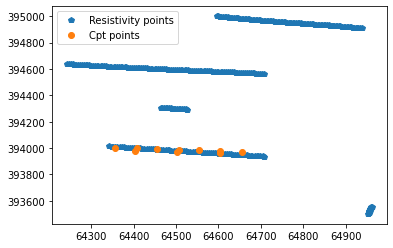

In [10]:
import matplotlib.pyplot as plt
plt.plot(location_resistivity[0], location_resistivity[1], label="Resistivity points", marker="p", linestyle="None")
plt.plot(location_cpt[0], location_cpt[1], label="Cpt points", marker="o", linestyle="None")
plt.legend()

## Use DataFusionTools to "fuse" data

Create cpt inputs

In [9]:
cpts_list = []
for name, item in cpts.items():
    location = dft.data_input.Geometry(x=item["coordinates"][0], y=item["coordinates"][1], z=0)
    cpts_list.append(
        dft.data_input.Data(
                            location=location,
                            independent_variable=dft.data_input.Variable(value=item["NAP"], label="NAP"),
                            variables=[
                                dft.data_input.Variable(value=item["water"], label="water"),
                                dft.data_input.Variable(value=item["tip"], label="tip"),
                                dft.data_input.Variable(value=item["IC"], label="IC"),
                                dft.data_input.Variable(value=item["friction"], label="friction"),
                            ],
        )
    )

Create resistivity inputs

In [10]:
    resistivity_list = []
    for name, item in resistivity.items():
        location = dft.data_input.Geometry(x=item["coordinates"][0], y=item["coordinates"][1], z=0)
        resistivity_list.append(
            dft.data_input.Data(
                                location=location,
                                independent_variable=dft.data_input.Variable(value=item["NAP"], label="NAP"),
                                variables=[dft.data_input.Variable(value=item["resistivity"], label="resistivity")],
            )
        )

Fuse the data with each other

In [11]:
create_features = dft.utils.CreateInputsML()
aggregated_features = create_features.find_closer_points(
    input_data=cpts_list,
    combined_data=resistivity_list,
    aggregate_method=dft.utils.AggregateMethod.MEAN,
    aggregate_variable="resistivity",
    interpolate_on_independent_variable=True,
    number_of_points=10,
)

## Define and get inputs for the Neural Network

In this case we want to use the resistivity data in order to get a good approximation of the IC value. Thus creating a relationship between abundant (geophysical survey) and sparse (CPTs) data.
The created model will therefore look like the following figure. 

![title](static\model_ml_deltares.png)

Let's create the features and targets using the datafusiontools package

In [12]:
for aggregated_feature in aggregated_features:
    create_features.add_features(
        aggregated_feature,
        ["resistivity"],
        use_independent_variable=True,
        use_location_as_input=(True, True, False),
    )
    create_features.add_targets(aggregated_feature, ["IC"])

The dataset is split into training, test and validation data.


- Training Set: The dataset that we feed our model to learn potential underlying patterns and relationships.
- Validation Set: The dataset that we use to understand our model's performance across different model types and hyperparameter choices.
- Test Set: The dataset that we use to approximate our model's unbiased accuracy.

In [13]:
create_features.split_train_test_data(train_percentage=0.7, validation_percentage_on_test=0.5)

The data can be retrieved using the data fusion tools.

In [14]:
training_data = create_features.get_features_train(flatten=False)
target_data = create_features.get_targets_train(flatten=False)
test_training = create_features.get_features_test(flatten=False)
test_target = create_features.get_targets_test(flatten=False)
validation_training = create_features.get_features_validation(flatten=False)
validation_target = create_features.get_targets_validation(flatten=False)

Let's take a look at the dataset in terms of inputs and outputs

The inputs are:

In [15]:
create_features.get_feature_names()

['resistivity', 'NAP', 'location_x', 'location_y']

Text(0.5, 1.0, 'IC')

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\mat

findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
findfont: score(FontEntry(fname='C:\\Users\\Smyrniou\\Anaconda3\\envs\\tutorial\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', vari

findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candarai.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mvboli.ttf', name='MV Boli', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARLRDBD.TTF', name='Arial Rounded MT Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SNAP____.TTF', name='Snap ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', wei

findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKBI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candaraz.ttf', name='Candara', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCB____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='nor

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HARNGTON.TTF', name='Harrington', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\eucsymb.ttf', name='Euclid Symbol', style='normal', variant=

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarai.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', varian

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\wingding.ttf', name='Wingdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VINERITC.TTF', name='Viner Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAB.TTF', name='Book Antiqua', 

findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 4.6863636363636365
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NIAGENG.TTF', name='Niagara Engraved', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OCRAEXT.TTF', name='OCR A Extended', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CASTELAR.TTF', name='Castellar', style='normal'

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHIC.TTF', name='Century Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRLNSB.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MOD20.TTF', name='Modern No. 20', style='norma

findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-LIGHT.TTF', name='Dubai', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palab.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\VINERITC.TTF', name='Viner Hand ITC', 

findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNT.TTF', name='Elephant', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\framd.ttf', name='Franklin Gothic Medium', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TEMPSITC.TTF', name='Tempus Sans ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 7.8986363636363635
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCBLKAD.TTF', name='Blackad

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MAGNETOB.TTF', name='Magneto', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_PSTC.TTF', name='Bodoni MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\taile.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CB.TTF', name='Bodoni MT', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSDB.TTF', name='Berlin Sans FB Demi', style='normal', variant='

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-LIGHT.TTF', name='Dubai', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\euclidi.ttf', name='Euclid', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.6863636363636365
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LATINWD.TTF', name='Wide Latin', style='normal', var

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCM_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIST.TTF', name='Calisto MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCC____.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\l_10646.ttf', name='Lucida Sans Unicode', style='normal',

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\fences.ttf', name='Fences', style='normal', variant='normal', weight=5, stretch='normal', size='scalable')) = 10.42525
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\tahomabd.ttf', name='Tahoma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_BI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400, s

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 7.8986363636363635
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PER_____.TTF', name='Perpetua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMIT.TTF', name='Franklin Gothic Demi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuiz.ttf', name='Segoe UI', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MAIAN.TTF', name='Maiandra GD', style='nor

findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal',

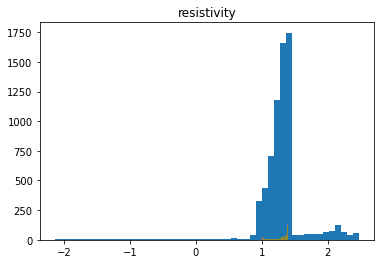

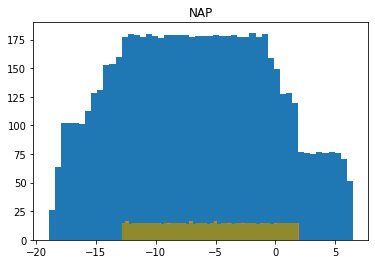

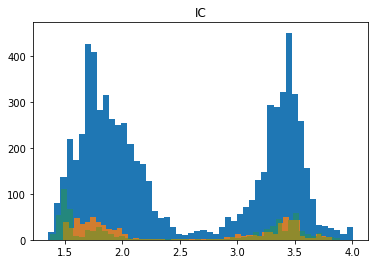

In [16]:
import matplotlib.pyplot as plt
n_bins = 50
for i in [0, 1]:
    fig, axs = plt.subplots(1, 1)
    axs.hist(training_data.T[i], bins=n_bins, label="Train")
    axs.hist(test_training.T[i], bins=n_bins, alpha=0.8, label="Test")
    axs.hist(validation_training.T[i], bins=n_bins, label="Validation", alpha=0.4)
    axs.set_title(create_features.get_feature_names()[i])
fig, axs = plt.subplots(1, 1)
axs.hist(target_data, bins=n_bins, label="Train")
axs.hist(test_target, bins=n_bins, alpha=0.8, label="Test")
axs.hist(validation_target, bins=n_bins, label="Validation", alpha=0.4)
axs.set_title("IC")

In [17]:
print(training_data.T.shape)

(4, 6955)


In [18]:
print(test_training.shape)

(744, 4)


In [19]:
print(validation_training.shape)

(743, 4)


In [58]:
nn = dft.machine_learning.bayesian_neural_network.BayesianNeuralNetwork(
    classification=False,
    nb_hidden_layers=2,
    nb_neurons=[8, 8],
    activation_fct=dft.enumeration_classes.ActivationFunctions.sigmoid,
    optimizer=dft.enumeration_classes.Optimizer.Adadelta,
    epochs=100,
    batch=14,
    feature_names=create_features.get_feature_names(),
    learning_rate=0.0001,
    validation_features=validation_training,
    validation_targets=validation_target,
)

In [59]:
nn.train(training_data,target_data)



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 batch_normalization_1 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_variational_2 (DenseV  (None, 8)                860       
 ariational)                                                     
                                                                 
 dense_variational_3 (DenseV  (None, 8)                2700      
 ariational)                                                     
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                           

497/497 [==============================] - 6s 12ms/step - loss: 0.9329 - mse: 0.8862 - mae: 0.7249 - val_loss: 1.2079 - val_mse: 1.1969 - val_mae: 0.8783
Epoch 91/100
497/497 [==============================] - 6s 12ms/step - loss: 0.9333 - mse: 0.9167 - mae: 0.7389 - val_loss: 1.2583 - val_mse: 1.2392 - val_mae: 0.8857
Epoch 92/100
497/497 [==============================] - 6s 11ms/step - loss: 0.9244 - mse: 0.8731 - mae: 0.7203 - val_loss: 1.2537 - val_mse: 1.3326 - val_mae: 0.9276
Epoch 93/100
497/497 [==============================] - 6s 12ms/step - loss: 0.9155 - mse: 0.8973 - mae: 0.7313 - val_loss: 1.3091 - val_mse: 1.2474 - val_mae: 0.9032
Epoch 94/100
497/497 [==============================] - 6s 12ms/step - loss: 0.9237 - mse: 0.8974 - mae: 0.7305 - val_loss: 1.3105 - val_mse: 1.1681 - val_mae: 0.8701
Epoch 95/100
497/497 [==============================] - 6s 12ms/step - loss: 0.9203 - mse: 0.8840 - mae: 0.7272 - val_loss: 1.2691 - val_mse: 1.2711 - val_mae: 0.9062
Epoch 96/10

In [64]:
nn.predict(test_training)

24/24 [==============================] - 1s 4ms/step


In [65]:
import matplotlib.image as mpimg

In [66]:
nn.plot_cost_function(output_folder=Path("test_bnn"))

STREAM b'IHDR' 16 13
STREAM b'tEXt' 41 57
STREAM b'pHYs' 110 9
STREAM b'IDAT' 131 12229


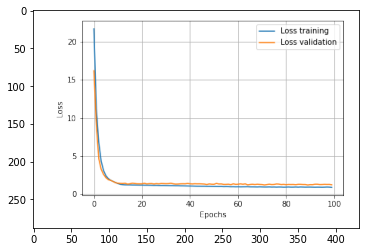

In [67]:
img = mpimg.imread('test_bnn\performance.png')
imgplot = plt.imshow(img)

In [68]:
nn.plot_confidence_band(test_target, output_folder=Path("test_bnn"))

STREAM b'IHDR' 16 13
STREAM b'tEXt' 41 57
STREAM b'pHYs' 110 9
STREAM b'IDAT' 131 22739


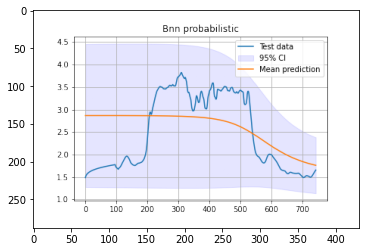

In [69]:
img = mpimg.imread('test_bnn\confidence_band_bnn.png')
imgplot = plt.imshow(img)

## Predict IC from all resistivity points

In [70]:
depths = np.array([resistivity_point.independent_variable.value  for resistivity_point in resistivity_list]).flatten()
res = np.array([resistivity_point.get_variable("resistivity").value  for resistivity_point in resistivity_list]).flatten()
x_loc = np.array([[resistivity_point.location.x] * len(resistivity_point.independent_variable.value) for resistivity_point in resistivity_list]).flatten()
y_loc = np.array([[resistivity_point.location.y] * len(resistivity_point.independent_variable.value) for resistivity_point in resistivity_list]).flatten()
data = np.array([depths, res, x_loc, y_loc])
    

In [71]:
data.shape

(4, 6180)

In [72]:
nn.predict(data.T)

194/194 [==============================] - 1s 3ms/step


The predicted IC variables

In [73]:
nn.prediction

array([[3.21618  ],
       [2.0889602],
       [4.6811485],
       ...,
       [3.2786055],
       [3.2733388],
       [4.2968745]], dtype=float32)

Add results into the Data class

In [74]:
from datafusiontools._core.data_input import Data, Geometry, Variable

start = 0 
for counter, resistivity_point in enumerate(resistivity_list):
    spread = len(resistivity_point.independent_variable.value)
    IC_nn = nn.prediction[start:(start + spread)]
    IC_variable = Variable(label="IC", value=IC_nn.flatten())
    resistivity_point.variables.append(IC_variable)
    resistivity_list[counter] = resistivity_point
    start += spread

Let's plot the dikes around the area with the results and pick a location to make a D-Stability model

STREAM b'IHDR' 16 13
STREAM b'tEXt' 41 57
STREAM b'pHYs' 110 9
STREAM b'IDAT' 131 25253


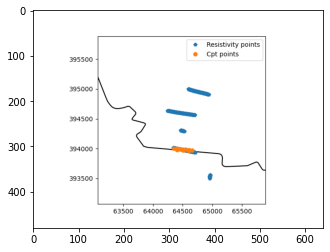

In [75]:
img = mpimg.imread('static\dijktraject.png')
imgplot = plt.imshow(img)

Get ANH top surface

In [76]:
from datafusiontools._core.data_input import Data, Geometry, Variable
from DataFusionTools.interpolation.interpolation_2d_slice import Interpolate2DSlice
from datafusiontools._core.data_input import Geometry
from DataFusionTools.interpolation.interpolation import Nearest
from DataFusionTools.d_series_parser.clustering import ClusteringLayers
from DataFusionTools.d_series_parser.d_stability_parser import DStabilityModel

In [77]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1),
               np.linspace(p1[1], p2[1], parts+1))

Define location points

In [78]:
location_1 = Geometry(x=64500, y=393930, z=0)
location_2 = Geometry(x=64700, y=393980, z=0)

In [79]:
surface_line = list(getEquidistantPoints((location_1.x,location_1.y), (location_2.x,location_2.y), 100))

In [80]:
from DataFusionTools.spatial_utils import SpatialUtils, TypesAhn
spatial_utils = SpatialUtils(TypesAhn.AHN3)
spatial_utils.get_ahn_surface_line(np.array(surface_line))

Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
Starting new HTTP connection (1): 

Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63530.0%2C+392937.5%2C+65530.0%2C+394937.5&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 184
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63532.0%2C+392938.0%2C+65532.0%2C+394938.0&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 184
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
http://geodata.nationaalgeoregister.nl:80 "

http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63550.0%2C+392942.5%2C+65550.0%2C+394942.5&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 183
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63558.0%2C+392944.5%2C+65558.0%2C+394944.5&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 182
Starting new HTTP connection (1): geodata.nationaalgeoregister.nl:80
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application

http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63602.0%2C+392955.5%2C+65602.0%2C+394955.5&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 181
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63598.0%2C+392954.5%2C+65598.0%2C+394954.5&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 181
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_d

http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63644.0%2C+392966.0%2C+65644.0%2C+394966.0&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 183
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63636.0%2C+392964.0%2C+65636.0%2C+394964.0&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 182
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_d

http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63688.0%2C+392977.0%2C+65688.0%2C+394977.0&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 186
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_dsm&query_layers=ahn3_05m_dsm&bbox=63692.0%2C+392978.0%2C+65692.0%2C+394978.0&i=2000&j=2000&max_workers=500 HTTP/1.1" 200 185
http://geodata.nationaalgeoregister.nl:80 "GET /ahn3/wms?request=GetFeatureInfo&service=WMS&crs=EPSG%3A28992&response_crs=EPSG%3A28992&width=4000&height=4000&info_format=application%2Fjson&styles=ahn3%3Aahn3_05m_detail&version=1.3.0&layers=ahn3_05m_d

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


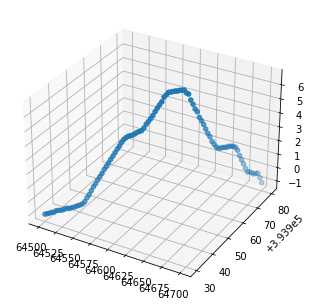

In [81]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(spatial_utils.AHN_data.T[0], spatial_utils.AHN_data.T[1], spatial_utils.AHN_data.T[2])


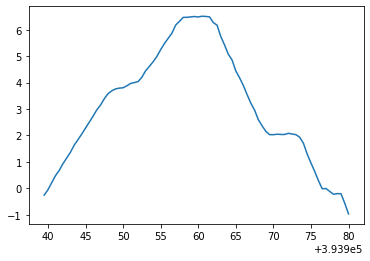

In [82]:
plt.plot(spatial_utils.AHN_data.T[1][19:], spatial_utils.AHN_data.T[2][19:])

In [83]:
interpolator_slice = Nearest()
interpolator = Interpolate2DSlice()
points_2d_slice, results_2d_slice = interpolator.get_2d_slice_extra(
    location_1=location_1,
    location_2=location_2,
    data=cpts_list,
    interpolate_variable="IC",
    number_of_points=100,
    number_of_independent_variable_points=120,
    top_surface=spatial_utils.AHN_data,
    bottom_surface=np.array(
        [[location_1.x, location_1.y, -10], [location_2.x, location_2.y, -10]]
    ),
)

In [84]:
np.array(points_2d_slice).shape

(100, 120, 3)

In [85]:
np.array(results_2d_slice).shape

(100, 120)

In [86]:
# re-arange results
for counter, points in enumerate(points_2d_slice):
    for double_count, row in enumerate(points_2d_slice[counter]):
        row.append(results_2d_slice[counter][double_count])
        points_2d_slice[counter][double_count] = row
points_2d_slice = np.array(points_2d_slice)
points_2d_slice = np.reshape(
    points_2d_slice, (points_2d_slice.shape[0] * points_2d_slice.shape[1], 4)
)
points_2d_slice = np.array(
    [points_2d_slice.T[0, :], points_2d_slice.T[2, :], points_2d_slice.T[3, :]]
).T

In [87]:
points_2d_slice

array([[ 6.45000000e+04, -1.00000000e+01,  2.08057594e+00],
       [ 6.45000000e+04, -9.92455462e+00,  2.08170310e+00],
       [ 6.45000000e+04, -9.84910924e+00,  2.08394690e+00],
       ...,
       [ 6.47000000e+04, -1.11979831e+00,  1.86058798e+00],
       [ 6.47000000e+04, -1.04389915e+00,  1.81592286e+00],
       [ 6.47000000e+04, -9.67999995e-01,  1.78569170e+00]])

locator: <matplotlib.ticker.AutoLocator object at 0x00000188A19BE7D0>


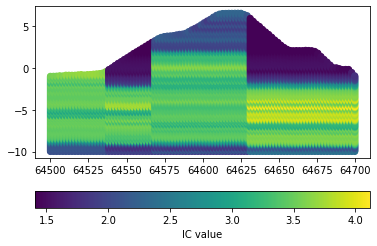

In [88]:
plt.scatter(points_2d_slice.T[0], points_2d_slice.T[1], c=points_2d_slice.T[2])
plt.colorbar(label="IC value", orientation="horizontal")

## Clustering the interpolated 2d surface

In [89]:
cluster_model = ClusteringLayers()
cluster_model.cluster_2d_surface(points_2d_slice, k_candidates=20)

divide by zero encountered in double_scalars
STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.


locator: <matplotlib.ticker.AutoLocator object at 0x000001889DF11A20>


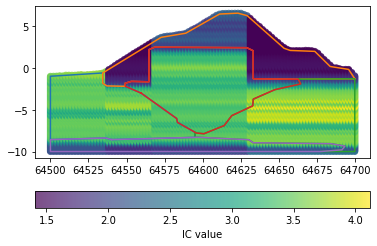

In [90]:
plt.scatter(points_2d_slice.T[0], points_2d_slice.T[1], c=points_2d_slice.T[2], alpha=0.7)
plt.colorbar(label="IC value", orientation="horizontal")
for polygon in cluster_model.simplified_polygons:
    plt.plot(polygon.exterior.xy[0], polygon.exterior.xy[1])

## Clustered layers to D-Stability model

In the first example the D-Stability model will be constructed using default soil layers

In [91]:
from DataFusionTools.d_series_parser.d_stability_parser import DStabilityModel

In [92]:
filename = "test_model_default.stix"
model = DStabilityModel.create_model(cluster_model.simplified_polygons, filename, soil_list=None)

We can also use the mean value of the clustered polygons to get soil parameters

In [93]:
def soil_type_from_IC(ic: float):
    """
    Classifies IC based on figure 22 of Robertson, 2010, page 27
    """
    if ic < 1.31:
        return {
            "name": "dense sand",
            "code": 7,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 22},
                "unsaturated_weight": {"mean": 17},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 32.5},
            },
        }
    elif ic >= 1.31 and ic < 2.05:
        return {
            "name": "silty sand",
            "code": 6,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 22},
                "unsaturated_weight": {"mean": 17},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 30},
            },
        }
    elif ic >= 2.05 and ic < 2.6:
        return {
            "name": "sandy silt",
            "code": 5,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 21},
                "unsaturated_weight": {"mean": 19},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 29},
            },
        }
    elif ic >= 2.6 and ic < 2.95:
        return {
            "name": "silty clay",
            "code": 4,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 20},
                "unsaturated_weight": {"mean": 19},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 27},
            },
        }
    elif ic >= 2.95 and ic < 3.6:
        return {
            "name": "silty clay",
            "code": 3,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 18},
                "unsaturated_weight": {"mean": 18},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 27},
            },
        }
    else:
        return {
            "name": "Organic soil",
            "code": 2,
            "soil_weight_parameters": {
                "saturated_weight": {"mean": 13},
                "unsaturated_weight": {"mean": 13},
            },
            "mohr_coulomb_parameters": {
                "cohesion": {"mean": 1},
                "friction_angle": {"mean": 15},
            },
        }

In [94]:
soils_dictionary = [soil_type_from_IC(ic_value * 3.6) for ic_value in cluster_model.extracted_value_per_polygon]

In [95]:
filename = "test_model_IC.stix"
model = DStabilityModel.create_model(cluster_model.simplified_polygons, filename, soils_dictionary)